In [39]:

import os
import numpy as np
from tqdm import tqdm
import pandas as pd

import time
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import kagglehub

# Download latest version
path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\johnn\.cache\kagglehub\datasets\birdy654\cifake-real-and-ai-generated-synthetic-images\versions\3


In [18]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define directory paths
train_dir = r'C:\Users\johnn\CTP\CTP\train'
test_dir = r'C:\Users\johnn\CTP\CTP\test'

# Define image size and batch size
IMG_HEIGHT, IMG_WIDTH = 128, 128
BATCH_SIZE = 32

# Data Augmentation for Training Data
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values to 0-1
    rotation_range=20,            # Randomly rotate images by 20 degrees
    width_shift_range=0.2,        # Randomly shift images horizontally by 20%
    height_shift_range=0.2,       # Randomly shift images vertically by 20%
    shear_range=0.2,              # Shear transformation
    zoom_range=0.2,               # Randomly zoom in images
    horizontal_flip=True,         # Randomly flip images horizontally
    fill_mode='nearest'           # Fill in pixels with nearest values after transformations
)

# Only rescale for test data, no augmentation
test_datagen = ImageDataGenerator(rescale=1./255)

# Load training data with data augmentation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'           # For binary classification (real vs fake)
)

# Load test data without augmentation
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
# Display the class names for the training and test generators
print("Training classes:", train_generator.class_indices)
print("Test classes:", test_generator.class_indices)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Training classes: {'FAKE': 0, 'REAL': 1}
Test classes: {'FAKE': 0, 'REAL': 1}


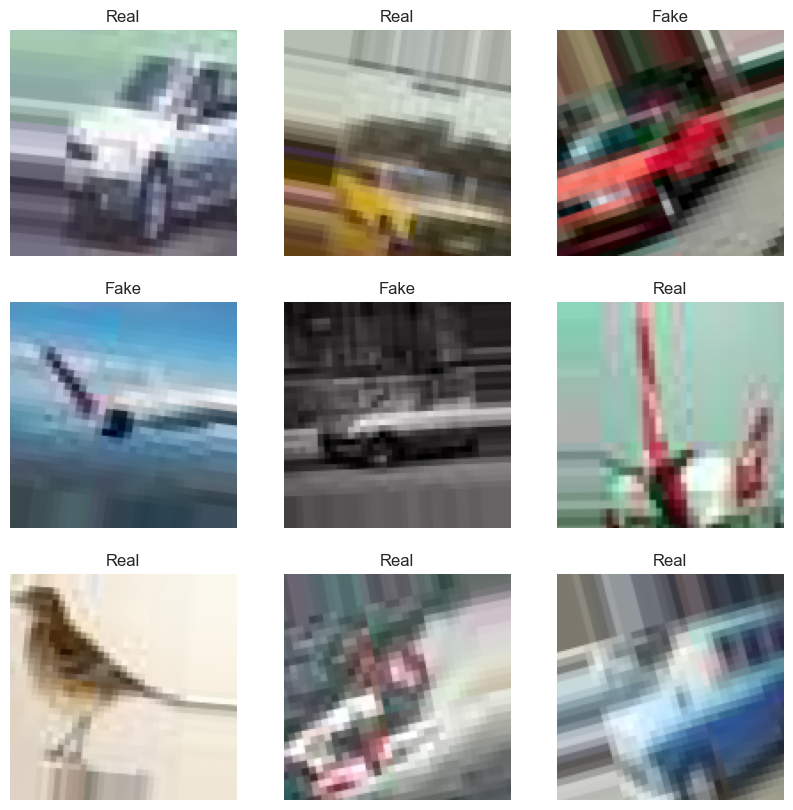

In [19]:
import matplotlib.pyplot as plt

# Get a batch of images and labels
images, labels = next(train_generator)

# Set up a grid to display images
plt.figure(figsize=(10, 10))
for i in range(9):  # Display the first 9 images
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title("Real" if labels[i] == 1 else "Fake")  # Assuming 1 = Real and 0 = Fake
    plt.axis('off')  # Hide axes for a cleaner display

plt.show()

In [20]:
import pandas as pd
import os
import tensorflow as tf

def load_and_preprocess_images(train_dir, img_size=(128, 128)):
    # Initialize lists for storing image details
    image_names = []
    labels = []
    pixel_arrays = []
    
    # Loop through the directories to get image paths, labels, and pixel arrays
    for label in os.listdir(train_dir):
        label_dir = os.path.join(train_dir, label)
        if os.path.isdir(label_dir):
            for img_name in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_name)
                
                # Load and preprocess the image
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                img_array = img_array / 255.0  # Normalize the pixel values
                
                # Append details to lists
                image_names.append(img_name)
                labels.append(label)
                pixel_arrays.append(img_array)
    
    # Create a DataFrame
    df = pd.DataFrame({
        'image_name': image_names,
        'label': labels,
        'pixel_array': pixel_arrays
    })
    
    return df

# Example usage
r'C:\Users\johnn\CTP\CTP\train'
df = load_and_preprocess_images(train_dir)


In [21]:
df.head()


,image_name,label,pixel_array
0,1000 (10).jpg,FAKE,"[[[0.44705883, 0.4392157, 0.44313726], [0.4470..."
1,1000 (2).jpg,FAKE,"[[[0.80784315, 0.8, 0.8039216], [0.80784315, 0..."
2,1000 (3).jpg,FAKE,"[[[0.6, 0.7254902, 0.8156863], [0.6, 0.7254902..."
3,1000 (4).jpg,FAKE,"[[[0.7058824, 0.79607844, 0.27058825], [0.7058..."
4,1000 (5).jpg,FAKE,"[[[0.019607844, 0.09803922, 0.0], [0.019607844..."


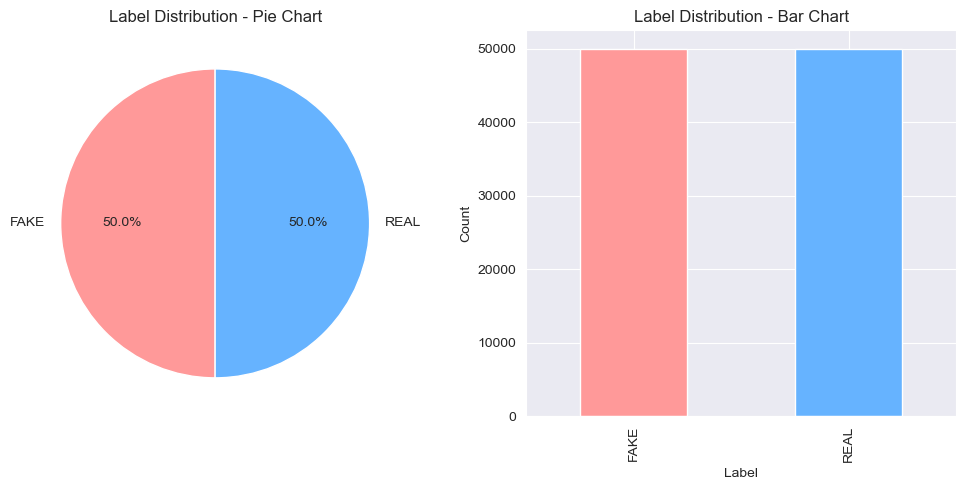

In [22]:
# Count the occurrences of each label
label_counts = df['label'].value_counts()

# Plot a pie chart
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
label_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title('Label Distribution - Pie Chart')
plt.ylabel('')

# Plot a bar chart
plt.subplot(1, 2, 2)
label_counts.plot.bar(color=['#ff9999','#66b3ff'])
plt.title('Label Distribution - Bar Chart')
plt.xlabel('Label')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [23]:
print("Null counter: ",df.isnull().sum())
print("Shape of the dataframe: ",df.shape)


Null counter:  image_name     0
label          0
pixel_array    0
dtype: int64
Shape of the dataframe:  (100000, 3)


In [24]:
#Same thing for the test data

import pandas as pd
import os
import tensorflow as tf

def load_and_preprocess_images(train_dir, img_size=(128, 128)):
    # Initialize lists for storing image details
    image_names = []
    labels = []
    pixel_arrays = []
    
    # Loop through the directories to get image paths, labels, and pixel arrays
    for label in os.listdir(train_dir):
        label_dir = os.path.join(train_dir, label)
        if os.path.isdir(label_dir):
            for img_name in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_name)
                
                # Load and preprocess the image
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                img_array = img_array / 255.0  # Normalize the pixel values
                
                # Append details to lists
                image_names.append(img_name)
                labels.append(label)
                pixel_arrays.append(img_array)
    
    # Create a DataFrame
    df = pd.DataFrame({
        'image_name': image_names,
        'label': labels,
        'pixel_array': pixel_arrays
    })
    
    return df

# Example usage
r'C:\Users\johnn\CTP\CTP\train'
df_test= load_and_preprocess_images(test_dir)


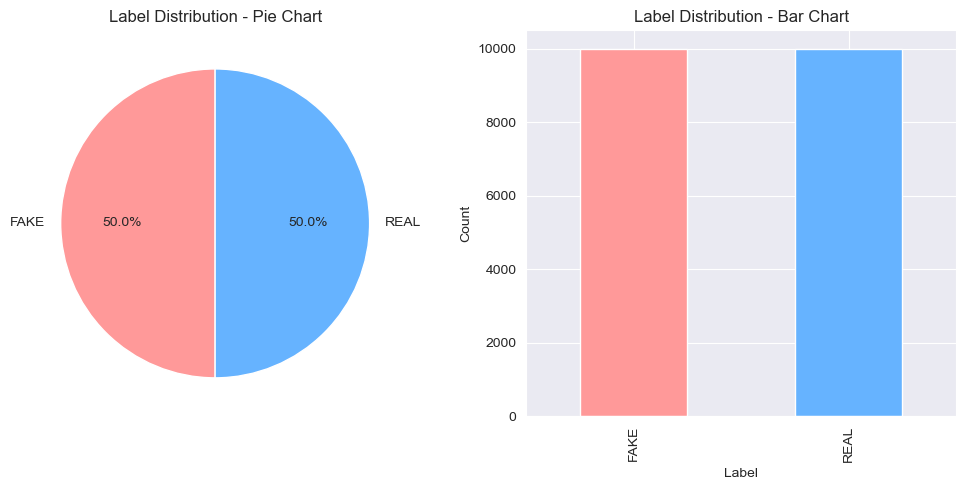

In [25]:
# Count the occurrences of each label
label_counts = df_test['label'].value_counts()

# Plot a pie chart
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
label_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title('Label Distribution - Pie Chart')
plt.ylabel('')

# Plot a bar chart
plt.subplot(1, 2, 2)
label_counts.plot.bar(color=['#ff9999','#66b3ff'])
plt.title('Label Distribution - Bar Chart')
plt.xlabel('Label')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [35]:
X = df['pixel_array']

X

0        [[[0.44705883, 0.4392157, 0.44313726], [0.4470...
1        [[[0.80784315, 0.8, 0.8039216], [0.80784315, 0...
2        [[[0.6, 0.7254902, 0.8156863], [0.6, 0.7254902...
3        [[[0.7058824, 0.79607844, 0.27058825], [0.7058...
4        [[[0.019607844, 0.09803922, 0.0], [0.019607844...
                               ...                        
99995    [[[0.6627451, 0.6666667, 0.6431373], [0.662745...
99996    [[[0.9529412, 0.9490196, 0.59607846], [0.95294...
99997    [[[0.39215687, 0.57254905, 0.7647059], [0.3921...
99998    [[[0.9882353, 1.0, 1.0], [0.9882353, 1.0, 1.0]...
99999    [[[0.60784316, 0.627451, 0.6392157], [0.607843...
Name: pixel_array, Length: 100000, dtype: object

In [41]:
y = df['label']

y

0        FAKE
1        FAKE
2        FAKE
3        FAKE
4        FAKE
         ... 
99995    REAL
99996    REAL
99997    REAL
99998    REAL
99999    REAL
Name: label, Length: 100000, dtype: object

In [42]:

oversampler = RandomOverSampler(sampling_strategy="auto")

X, y = oversampler.fit_resample(X.values.reshape(-1,1), y)

In [43]:
X

array([[array([[[0.44705883, 0.4392157 , 0.44313726],
                [0.44705883, 0.4392157 , 0.44313726],
                [0.46666667, 0.45882353, 0.4627451 ],
                ...,
                [0.41568628, 0.4       , 0.39607844],
                [0.21176471, 0.19607843, 0.19215687],
                [0.21176471, 0.19607843, 0.19215687]],

               [[0.44705883, 0.4392157 , 0.44313726],
                [0.44705883, 0.4392157 , 0.44313726],
                [0.46666667, 0.45882353, 0.4627451 ],
                ...,
                [0.41568628, 0.4       , 0.39607844],
                [0.21176471, 0.19607843, 0.19215687],
                [0.21176471, 0.19607843, 0.19215687]],

               [[0.49803922, 0.49019608, 0.49411765],
                [0.49803922, 0.49019608, 0.49411765],
                [0.49803922, 0.49019608, 0.49411765],
                ...,
                [0.31764707, 0.3019608 , 0.29803923],
                [0.18039216, 0.16470589, 0.16078432],
               

In [44]:
y

0        FAKE
1        FAKE
2        FAKE
3        FAKE
4        FAKE
         ... 
99995    REAL
99996    REAL
99997    REAL
99998    REAL
99999    REAL
Name: label, Length: 100000, dtype: object

In [45]:
print("X.shape =", X.shape)

print("y.shape =", y.shape)

X.shape = (100000, 1)
y.shape = (100000,)


In [46]:
X = pd.Series(X.flatten())

X

0        [[[0.44705883, 0.4392157, 0.44313726], [0.4470...
1        [[[0.80784315, 0.8, 0.8039216], [0.80784315, 0...
2        [[[0.6, 0.7254902, 0.8156863], [0.6, 0.7254902...
3        [[[0.7058824, 0.79607844, 0.27058825], [0.7058...
4        [[[0.019607844, 0.09803922, 0.0], [0.019607844...
                               ...                        
99995    [[[0.6627451, 0.6666667, 0.6431373], [0.662745...
99996    [[[0.9529412, 0.9490196, 0.59607846], [0.95294...
99997    [[[0.39215687, 0.57254905, 0.7647059], [0.3921...
99998    [[[0.9882353, 1.0, 1.0], [0.9882353, 1.0, 1.0]...
99999    [[[0.60784316, 0.627451, 0.6392157], [0.607843...
Length: 100000, dtype: object

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'path_to_train_images'